<a href="https://colab.research.google.com/github/AfsanehCaden/Toxic_Comments_Classification/blob/main/Toxic_Cmnt_DistilBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import pandas as pd
import random

import tensorflow as tf
import transformers
import re

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
from torch.nn import BCEWithLogitsLoss

from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"afsanehcaden","key":"d4c29571ac10cdc3c225045768df33df"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:

!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
!unzip jigsaw-toxic-comment-classification-challenge.zip -d dataset
!unzip dataset/train.csv.zip -d dataset
!unzip dataset/test.csv.zip -d dataset
!unzip dataset/test_labels.csv.zip -d dataset

 68% 36.0M/52.6M [00:00<00:00, 196MB/s] 
100% 52.6M/52.6M [00:00<00:00, 192MB/s]
Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: dataset/sample_submission.csv.zip  
  inflating: dataset/test.csv.zip    
  inflating: dataset/test_labels.csv.zip  
  inflating: dataset/train.csv.zip   
Archive:  dataset/train.csv.zip
  inflating: dataset/train.csv       
Archive:  dataset/test.csv.zip
  inflating: dataset/test.csv        
Archive:  dataset/test_labels.csv.zip
  inflating: dataset/test_labels.csv  


**Import the datasets**

In [ ]:
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')
test_labels_df = pd.read_csv('dataset/test_labels.csv')


**Explore the train_df**

In [ ]:
# Select only the label columns
labels = train_df.loc[:, 'toxic':'identity_hate']

# Create a boolean mask where each row has all zeroes for label columns
rows_with_all_zeros = labels.eq(0).all(axis=1)

# Apply this mask to the train_df to get the rows with all zero labels
non_toxic_train = train_df[rows_with_all_zeros].copy()
non_toxic_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,143346.0,143346.0,143346.0,143346.0,143346.0,143346.0
mean,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Create a boolean mask where each row has at least one label with a value of 1
rows_with_any_ones = labels.eq(1).any(axis=1)

# Apply this mask to the train_df to get the rows with at least one label being 1
toxic_train = train_df[rows_with_any_ones].copy()
toxic_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,16225.000000,16225.000000,16225.000000,16225.000000,16225.000000,16225.000000
mean,0.942619,0.098305,0.520740,0.029461,0.485485,0.086595
std,0.232576,0.297736,0.499585,0.169099,0.499805,0.281249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Download "stopwords" list** which we need in cleaning the comment_text in next step

In [ ]:
import nltk

# Download the punkt tokenizer models
nltk.download('punkt')

# Download the stopwords list
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Cleaning comment_text** to help reduce noise and improve the model's ability
to learn from the data

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def clean_text(text):

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Replace URLs with a special token
    text = re.sub(r'http\S+|www\S+', '[URL]', text)

    # Replace email addresses with a special token
    text = re.sub(r'\S+@\S+', '[EMAIL]', text)

    # Convert text to lowercase
    text = text.lower()

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove text within double equals (commonly used for headings in Wiki text)
    text = re.sub(r'==.*?==+', '', text)

    # Normalize whitespaces, replacing multiple spaces with just one
    text = re.sub(r'\s+', ' ', text).strip()

    # Replace newline characters and carriage returns with space
    text = text.replace('\n', ' ').replace('\r', ' ')

    return text

# Aplly clean_text on train_df and test_df
train_df['comment_text'] = train_df['comment_text'].apply(clean_text)
test_df['comment_text'] = test_df['comment_text'].apply(clean_text)


**Prepares the text data for input into a DistilBert model**

1- Import **DistilBertTokenizer** and **DistilBertForSequenceClassification** from the transformers package.

2- Initialize the tokenizer

3- Create **encode_text function** to encode the text data. It takes a list of text strings as input and encodes them using the tokenizer.

4- **Convert the text data into a list** and then passe this list to the encode_texts function to encode it.

5- **Extracting input_ids and attention_masks**. 'input_ids' are the token IDs used for model input, and 'attention_masks' help the model differentiate between meaningful data and padding.

In [ ]:
from transformers import BertTokenizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Function to encode the text data
def encode_texts(texts):
    return tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=128,           # Max length to truncate/pad
        padding='max_length',     # Pad to max_length
        truncation=True,          # Truncate to max_length
        return_attention_mask=True,  # Return attention masks
        return_tensors='pt',      # Return PyTorch tensors
    )

# Encode comment_text
train_texts = train_df['comment_text'].tolist()  # convert text data into a list
encoded_data = encode_texts(train_texts)         # Encode the text

# Retrieve input_ids and attention_mask from the encoded data dictionary
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

**Check the output of the tokenization process.** Print a few samples to visually inspect the token IDs and corresponding attention masks. It will help confirm that the encoding has been performed correctly.

In [ ]:
# Select an index to inspect, for example index 0
index_to_check = 0

# Print details of the selected example
print("Original Text:", train_df['comment_text'].iloc[index_to_check])
print("Encoded Input IDs:", input_ids[index_to_check])
print("Attention Mask:", attention_masks[index_to_check])


Original Text: explanation edits made username hardcore metallica fan reverted nt vandalisms closure gas voted new york dolls fac please nt remove template talk page since m retired now892053827
Encoded Input IDs: tensor([  101,  7526, 10086,  2015,  2081,  5310, 18442, 13076, 12392,  2050,
         5470, 16407, 23961,  3158,  9305, 22556,  8503,  3806,  5444,  2047,
         2259, 14421,  6904,  2278,  3531, 23961,  6366, 23561,  2831,  3931,
         2144,  1049,  3394,  2085,  2620,  2683, 11387, 22275,  2620, 22907,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
      

**Original Text:** The original text string is displayed as expected.
**Encoded Input IDs:** These are the token IDs for your text, correctly transformed by DistilBert tokenizer. Each number corresponds to a token in BERT's vocabulary.
**Attention Mask:** This array indicates which tokens in the input_ids should be paid attention to by the model. A value of 1 indicates a real token, and a 0 indicates a padding token. It ensures the model focuses only on the meaningful parts of your input data.

--------------------------------------------------------------------------------

**splitting the dataset** into training and validation sets using the train_test_split function from Scikit-learn. This separation is crucial before you apply any techniques like oversampling to avoid data leakage and to ensure that your model can generalize well to unseen data.

In [ ]:
from sklearn.model_selection import train_test_split

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Split data into training and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, labels,
    random_state=42,
    test_size=0.1
)

# Splitting the Attention Masks
train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    labels.index,  # Just a placeholder because we need the same split as above
    random_state=42,
    test_size=0.1
)


Check he sizes and label distributions of our \training and validation datasets after splitting.

In [ ]:
# Print the shapes to confirm
print("Train Inputs Shape:", train_inputs.shape)
print("Validation Inputs Shape:", validation_inputs.shape)
print("Train Labels Shape:", train_labels.shape)
print("Validation Labels Shape:", validation_labels.shape)
print("Train Masks Shape:", train_masks.shape)
print("Validation Masks Shape:", validation_masks.shape)

# Optionally, check the distribution of labels in both sets to ensure they are representative
print("Distribution of Labels in Training Set:\n", train_labels.sum(axis=0))
print("Distribution of Labels in Validation Set:\n", validation_labels.sum(axis=0))


Train Inputs Shape: torch.Size([143613, 128])
Validation Inputs Shape: torch.Size([15958, 128])
Train Labels Shape: (143613, 6)
Validation Labels Shape: (15958, 6)
Train Masks Shape: torch.Size([143613, 128])
Validation Masks Shape: torch.Size([15958, 128])
Distribution of Labels in Training Set:
 toxic            13814
severe_toxic      1447
obscene           7613
threat             441
insult            7086
identity_hate     1258
dtype: int64
Distribution of Labels in Validation Set:
 toxic            1480
severe_toxic      148
obscene           836
threat             37
insult            791
identity_hate     147
dtype: int64


<ipython-input-14-d246cc030e1c>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index, y=data.values, palette="coolwarm")


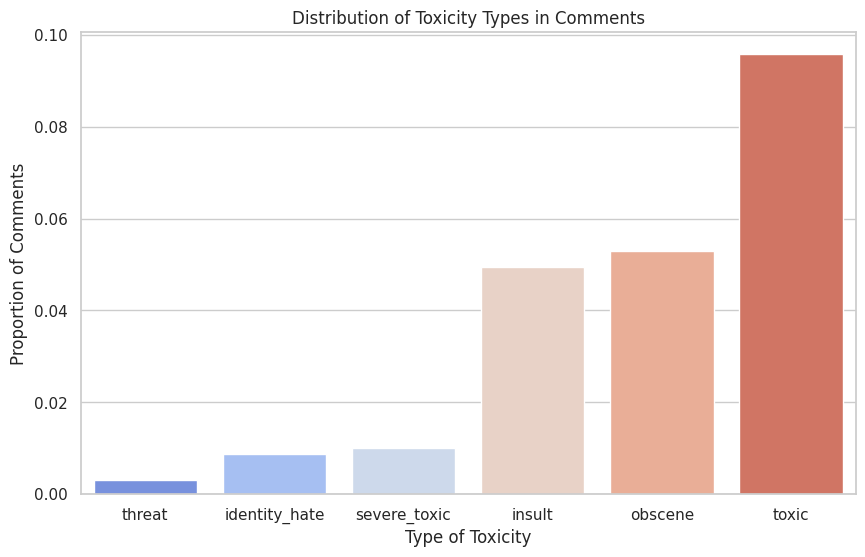

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# visualize the class distributions

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Data for plotting
data = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].mean().sort_values()

# Create a bar plot
sns.barplot(x=data.index, y=data.values, palette="coolwarm")

# Add informative labels and title
plt.xlabel('Type of Toxicity')
plt.ylabel('Proportion of Comments')
plt.title('Distribution of Toxicity Types in Comments')

# Show the plot
plt.show()


In [ ]:

# Isolating minority class data
severe_toxic_data = train_df[train_df['severe_toxic'] == 1]
threat_data = train_df[train_df['threat'] == 1]
identity_hate_data = train_df[train_df['identity_hate'] == 1]
toxic_data = train_df[train_df['toxic'] == 1]
obscene_data = train_df[train_df['obscene'] == 1]
insut_data = train_df[train_df['insult'] == 1]

# Isolating non-toxic data
non_toxic_data = train_df[(train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) == 0)]


In [ ]:
non_toxic_data.shape

(143346, 8)

In [ ]:
toxic_data = train_df[(train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) >= 1)]
toxic_data.shape

(16225, 8)

Balancing the dataset

In [ ]:
total_samples = len(non_toxic_data)  # Use the size of the non-toxic data as a baseline

# Categories to balance
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Dictionary to hold the oversampled data
oversampled_data = {}

# Define the target counts using uniform distribution for simplicity
target_count_per_category = int(total_samples / len(categories))  # Simplistic approach for demonstration

for category in categories:
    category_data = train_df[train_df[category] == 1]
    oversampled_data[category] = category_data.sample(target_count_per_category, replace=True, random_state=42)

# Combine all oversampled categories with a balanced subset of non-toxic data
balanced_train_df = pd.concat([data for data in oversampled_data.values()] + [non_toxic_data.sample(target_count_per_category * len(categories), random_state=42)])
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42)  # Shuffle the dataset


In [ ]:
balanced_train_df.shape

(286692, 8)

In [ ]:
balanced_train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,286692.000000,286692.000000,286692.000000,286692.000000,286692.000000,286692.000000
mean,0.477847,0.159258,0.384737,0.103302,0.378246,0.146300
std,0.499510,0.365917,0.486534,0.304354,0.484950,0.353407
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<ipython-input-21-3d4143b6c0bb>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index, y=data.values, palette="coolwarm")


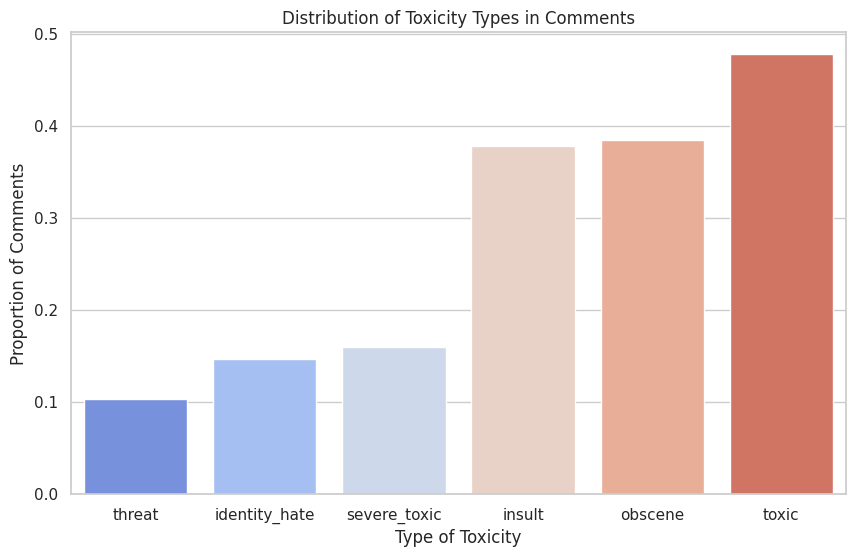

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Data for plotting
data = balanced_train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].mean().sort_values()

# Create a bar plot
sns.barplot(x=data.index, y=data.values, palette="coolwarm")

# Add informative labels and title
plt.xlabel('Type of Toxicity')
plt.ylabel('Proportion of Comments')
plt.title('Distribution of Toxicity Types in Comments')

# Show the plot
plt.show()


In [ ]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Function to encode the texts
def encode_texts(tokenizer, texts, max_length=128):
    return tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding='max_length',
        max_length=max_length,
        truncation=True,
        return_tensors='pt'
    )

# Extract texts and labels
texts = balanced_train_df['comment_text'].tolist()
labels = balanced_train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

# Encode the texts
encoded_data = encode_texts(tokenizer, texts)
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(labels, dtype=torch.float)




In [ ]:
# Split the data into training and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.1)

**Define a custom Focal loss function**

We use Focal loss as we have a highly imbalanced dataset. The focal loss helps to focus the training on hard examples and prevents the overwhelming number of easy negatives from dominating the training process. This approach ensures that the model learns effectively from all examples, not just the most frequent ones.

In [ ]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.float()  # Ensure labels are of type float

    def __getitem__(self, idx):
        item = {key: self.encodings[key][idx].clone().detach() for key in self.encodings}  # Ensure proper tensor handling
        item['labels'] = self.labels[idx].clone().detach()  # Clone to ensure independence from source
        return item

    def __len__(self):
        return self.labels.size(0)  # Return the first dimension size




In [ ]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW
from transformers import BertForSequenceClassification


# Initialize model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the custom Focal Loss
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=2.8):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

loss_fn = FocalLoss(alpha=0.25, gamma=2.8).to(device)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Define a train_and_validate function** which encapsulates a typical training and validation cycle for a PyTorch model with the inclusion of early stopping and learning rate adjustment based on the validation loss.

In [ ]:
import torch
from torch import nn
import copy

best_loss = np.inf
best_model = None
patience = 3
patience_counter = 0

def train_and_validate(model, train_loader, validation_loader, optimizer, scheduler, loss_fn, device, num_epochs=3):
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = loss_fn(outputs.logits, batch['labels'])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        average_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {average_train_loss:.4f}")

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in validation_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = loss_fn(outputs.logits, batch['labels'])
                total_val_loss += loss.item()

        average_val_loss = total_val_loss / len(validation_loader)
        print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {average_val_loss:.4f}")

        # Update the learning rate
        scheduler.step(average_val_loss)

        # Check if the current model is the best
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            # Save the best model
            #torch.save(model.state_dict(), 'best_model.pth')
            best_model = copy.deepcopy(model)
            print("Model improved and saved at epoch:", epoch + 1)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Stopping early due to no improvement in validation loss.")
                break

    # Load the best model state
    # model.load_state_dict(best_model)
    return best_model

# Assuming the device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


**Model Training and Validation**

- **Apply k-fold cross-validation** using PyTorch for training
- **Dataset Preparation**
- **DataLoader Setup**: SubsetRandomSampler uses the indices to sample elements randomly but without replacement from the dataset for training and validation.
- **Model and Optimizer Initialization**
- **Model Training and Validation**


In [ ]:
from sklearn.model_selection import KFold
import numpy as np

num_folds = 5
num_epochs = 3

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Assume 'input_ids', 'attention_masks', and 'labels' are your dataset tensors prepared outside this snippet
dataset = CustomDataset({'input_ids': input_ids, 'attention_mask': attention_masks}, labels)
indices = np.arange(len(dataset))

for fold, (train_idx, val_idx) in enumerate(kfold.split(indices)):
    print(f"Training fold {fold+1}/{num_folds}")

    # Creating DataLoaders for each fold using SubsetRandomSampler
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = DataLoader(dataset, batch_size=8, sampler=train_subsampler)
    validation_loader = DataLoader(dataset, batch_size=8, sampler=val_subsampler)

    # Reload the model and optimizer for each fold
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=6).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3)

    # Train and validate
    trained_model = train_and_validate(model, train_loader, validation_loader, optimizer, scheduler, loss_fn, device, num_epochs)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training fold 1/5
Epoch 1/3 - Train Loss: 0.0034
Epoch 1/3 - Validation Loss: 0.0016
Model improved and saved at epoch: 1
Epoch 2/3 - Train Loss: 0.0011
Epoch 2/3 - Validation Loss: 0.0009
Model improved and saved at epoch: 2
Epoch 3/3 - Train Loss: 0.0006
Epoch 3/3 - Validation Loss: 0.0009
Model improved and saved at epoch: 3
Training fold 2/5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 - Train Loss: 0.0034
Epoch 1/3 - Validation Loss: 0.0014
Model improved and saved at epoch: 1
Epoch 2/3 - Train Loss: 0.0011
Epoch 2/3 - Validation Loss: 0.0009
Model improved and saved at epoch: 2
Epoch 3/3 - Train Loss: 0.0006
Epoch 3/3 - Validation Loss: 0.0008
Model improved and saved at epoch: 3
Training fold 3/5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 - Train Loss: 0.0034
Epoch 1/3 - Validation Loss: 0.0014
Model improved and saved at epoch: 1
Epoch 2/3 - Train Loss: 0.0011
Epoch 2/3 - Validation Loss: 0.0009
Model improved and saved at epoch: 2
Epoch 3/3 - Train Loss: 0.0006
Epoch 3/3 - Validation Loss: 0.0009
Model improved and saved at epoch: 3
Training fold 4/5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 - Train Loss: 0.0034
Epoch 1/3 - Validation Loss: 0.0015
Model improved and saved at epoch: 1
Epoch 2/3 - Train Loss: 0.0011
Epoch 2/3 - Validation Loss: 0.0011
Model improved and saved at epoch: 2
Epoch 3/3 - Train Loss: 0.0006
Epoch 3/3 - Validation Loss: 0.0009
Model improved and saved at epoch: 3
Training fold 5/5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 - Train Loss: 0.0034
Epoch 1/3 - Validation Loss: 0.0015
Model improved and saved at epoch: 1
Epoch 2/3 - Train Loss: 0.0011
Epoch 2/3 - Validation Loss: 0.0010
Model improved and saved at epoch: 2
Epoch 3/3 - Train Loss: 0.0006
Epoch 3/3 - Validation Loss: 0.0009
Model improved and saved at epoch: 3


**Evaluate the model**

In [ ]:
import torch
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_probabilities = []
    all_labels = []

    with torch.no_grad():  # No need to track gradients for evaluation
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Convert logits to probabilities using sigmoid function
            probabilities = torch.sigmoid(logits)

            # Convert probabilities to binary predictions
            predictions = (probabilities > 0.5).long()

            # Move predictions and labels back to CPU for performance evaluation
            all_predictions.extend(predictions.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate evaluation metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    roc_auc = roc_auc_score(all_labels, all_probabilities, multi_class='ovr')

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

# Use the function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
validation_results = evaluate_model(trained_model, validation_loader, device)
print(f"Validation Results: {validation_results}")


Validation Results: {'precision': 0.9869643208972078, 'recall': 0.9919903375500604, 'f1': 0.9894597935087714, 'roc_auc': 0.9995159154618548}


In [ ]:
# Prepare 'test_df'

test_texts = test_df['comment_text'].tolist()
encoded_test_data = encode_texts(tokenizer, test_texts)

test_input_ids = encoded_test_data['input_ids']
test_attention_masks = encoded_test_data['attention_mask']


In [ ]:
class TestDataset(Dataset):
    def __init__(self, input_ids, attention_masks):
        self.input_ids = input_ids
        self.attention_masks = attention_masks

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx]
        }

# Create a dataset and dataloader for the test data
test_dataset = TestDataset(test_input_ids, test_attention_masks)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # Adjust batch size if necessary


In [ ]:
# to check if DataLoader works

for batch in test_loader:
    print(batch)
    break  # Remove or comment out this line once verification is successful


{'input_ids': tensor([[  101, 10930,  7743,  ...,     0,     0,     0],
        [  101, 14645,  2516,  ...,     0,     0,     0],
        [  101,  4216, 23564,  ...,     0,     0,     0],
        ...,
        [  101,  2758,  2157,  ...,     0,     0,     0],
        [  101,  5815,  2047,  ...,     0,     0,     0],
        [  101,  2783,  2597,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


**Generate probability predictions from a PyTorch model for the test_df dataset using a DataLoader**

In [ ]:
def generate_predictions(model, dataloader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs.logits).cpu().numpy()  # Convert logits to probabilities
            predictions.extend(probs)

    return predictions

# Calls the generate_predictions function to return probabilities
predictions = generate_predictions(trained_model, test_loader, device)


In [ ]:
# Prepare DataFrame for submission
submission_df = pd.DataFrame(predictions, columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
submission_df.insert(0, 'id', test_df['id'])


In [ ]:
submission_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.998417,0.764017,0.981266,0.006717,0.992117,0.249487
1,0000247867823ef7,0.035231,0.009029,0.018426,0.012779,0.024672,0.013083
2,00013b17ad220c46,0.055723,0.012046,0.015422,0.012117,0.045022,0.017708
3,00017563c3f7919a,0.025661,0.010136,0.016694,0.022513,0.028186,0.021647
4,00017695ad8997eb,0.083865,0.015753,0.011200,0.015307,0.029439,0.012955


In [ ]:
submission_df.to_csv('submission.csv', index=False)